In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

In [120]:
cleaned_feat_df = pd.read_csv('data/feat_new.csv')

In [121]:
# there were some rows not properly formated / has nonsensible values both in original "Fake.csv" dataset and after preprocessing
# so cleaning them
cleaned_feat_df = cleaned_feat_df[cleaned_feat_df.label.notna()]
cleaned_feat_df = cleaned_feat_df[cleaned_feat_df.text.notna()]
cleaned_feat_df.count()

text            44182
label           44182
token_length    44182
WTAG_NN         44147
WTAG_NNS        43830
WTAG_VBP        42824
WTAG_JJ         44030
WTAG_IN         38103
WTAG_VBD        43326
WTAG_VBN        40299
WTAG_CD         39463
WTAG_VBG        42220
WTAG_RB         41943
WTAG_VBZ        36814
WTAG_VB         38084
WTAG_MD         31630
WTAG_JJS        18427
fk_score        44182
flesh_score     44182
ari_score       44182
cl_score        44182
gf_score        44182
sentiment       44082
WTAG_JJR        15805
dtype: int64

In [122]:
cleaned_feat_df.fillna(0, inplace=True)
temp_df = cleaned_feat_df.copy()

In [123]:
Y = temp_df[["label"]].astype(int)
temp_df.drop(['label', 'text'], inplace=True, axis=1)
X = temp_df.astype(float)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [131]:
from collections import OrderedDict
import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.nn import BCELoss
from torch import nn
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module

class ClassificationModel(Module):
    # define model elements
    def __init__(self, num_layers, nodes_hidden, n_inputs=22, n_outputs=1):
        super(ClassificationModel, self).__init__()
        # input to first hidden layer
        layers = OrderedDict()

        if num_layers == 2:
            layers["hidden1"] = Linear(n_inputs, n_outputs)
            layers["act1"] = Sigmoid()
        else:
            nodes_layers = [n_inputs]
            for val in nodes_hidden:
                nodes_layers.append(val)
            nodes_layers.append(n_outputs)

            for i in range(len(nodes_layers) - 1):
                keyH = "hidden" + str(i + 1)
                keyA = "act" + str(i + 1)

                layers[keyH] = Linear(nodes_layers[i], nodes_layers[i + 1])
                if i != (len(nodes_layers) - 2):
                    layers[keyA] = ReLU()
                else:
                    layers[keyA] = Sigmoid()

        self.network = nn.Sequential(layers)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        return self.network(X)


In [132]:
x_train, val_train, y_train, val_test = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

In [133]:
from torch.utils.data import Dataset
import numpy

class CustomTorchDataset(Dataset):
    def __init__(self, features, labels, target_transform=None):
        self.X = features.to_numpy()
        self.Y_df = labels
        self.Y = labels.to_numpy()
        self.X = self.X.astype('float32')

        self.no_classes = len(set(self.Y_df.label))
        self.Y = self.Y.astype('float32')
        self.data_stat()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        label = self.Y[idx]
        return features, label

    def data_stat(self):
        print(f"\nNumber of classes in the dataset: {str(self.no_classes)}")
        print(f"Number of instances in class real: {len(self.Y_df[self.Y_df.label == 0])}")
        print(f"Number of instances in class fake: {len(self.Y_df[self.Y_df.label == 1])}")

In [134]:
print("\nDescribing train data...")
train_dataset = CustomTorchDataset(x_train, y_train)
print("\nDescribing test data...")
test_dataset = CustomTorchDataset(x_test, y_test)
print("\nDescribing validation data...")
val_dataset = CustomTorchDataset(val_train, val_test)


Describing train data...

Number of classes in the dataset: 2
Number of instances in class real: 10944
Number of instances in class fake: 11676

Describing test data...

Number of classes in the dataset: 2
Number of instances in class real: 4280
Number of instances in class fake: 4557

Describing validation data...

Number of classes in the dataset: 2
Number of instances in class real: 2728
Number of instances in class fake: 2928


In [142]:
def train_model(train_dataset, batch_size, lrn_rt, model):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=lrn_rt, momentum=0.09)
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_val = 0
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        output = model(inputs)
        # calculate loss
        loss = criterion(output, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

        loss_val = loss.item()

    print(f"loss: {loss_val:>7f}")
    return {"loss": loss_val}


def evaluate_model(dataset, model):
    dl = DataLoader(dataset, batch_size=100, shuffle=True)
    size = len(dl.dataset)
    num_batches = len(dl)
    test_loss = 0
    loss_fn = BCELoss()

    predictions = []

    with torch.no_grad():
        for X, y in dl:
            pred = model(X)
            out = y.numpy()

            test_loss += loss_fn(pred, y).item()
            predictions.extend(np.round(pred.detach()).numpy().flatten())

    test_loss /= num_batches

    return {"predictions": predictions, "loss": test_loss}

In [143]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
def print_eval_results(y_data, result):
    print(f"Avg loss: {result['loss']:>8f}")
    predictions = result['predictions']
    print(f"Accuracy : {round(accuracy_score(y_data.label, predictions) * 100, 2)}")
    print(f"Classification report: \n\n{classification_report(y_data.label, predictions)}")
    ConfusionMatrixDisplay.from_predictions(y_data.label, predictions)
    plt.show()


Running training with following hyper parameters:
Number of epochs: 50
Batch size: 250
Learning rate: 0.01

Epoch 1
-------------------------------

Training...
loss: 0.686844

Validation...
Accuracy: 51.38 %, Avg loss: 0.677387 


Epoch 2
-------------------------------

Training...
loss: 0.684347

Validation...
Accuracy: 50.8 %, Avg loss: 0.672668 


Epoch 3
-------------------------------

Training...
loss: 0.680951

Validation...
Accuracy: 50.76 %, Avg loss: 0.706974 


Epoch 4
-------------------------------

Training...
loss: 0.618885

Validation...
Accuracy: 50.51 %, Avg loss: 0.676700 


Epoch 5
-------------------------------

Training...
loss: 0.685455

Validation...
Accuracy: 51.06 %, Avg loss: 0.676585 


Epoch 6
-------------------------------

Training...
loss: 0.656955

Validation...
Accuracy: 51.22 %, Avg loss: 0.677312 


Epoch 7
-------------------------------

Training...
loss: 0.642836

Validation...
Accuracy: 52.05 %, Avg loss: 0.677502 


Epoch 8
----------------

loss: 0.699873

Validation...
Accuracy: 51.77 %, Avg loss: 0.692605 


Epoch 16
-------------------------------

Training...
loss: 0.702090

Validation...
Accuracy: 51.77 %, Avg loss: 0.692608 


Epoch 17
-------------------------------

Training...
loss: 0.693693

Validation...
Accuracy: 51.77 %, Avg loss: 0.692459 


Epoch 18
-------------------------------

Training...
loss: 0.690454

Validation...
Accuracy: 51.77 %, Avg loss: 0.692469 


Epoch 19
-------------------------------

Training...
loss: 0.685664

Validation...
Accuracy: 51.77 %, Avg loss: 0.692563 


Epoch 20
-------------------------------

Training...
loss: 0.690707

Validation...
Accuracy: 51.77 %, Avg loss: 0.692519 


Epoch 21
-------------------------------

Training...
loss: 0.690129

Validation...
Accuracy: 51.77 %, Avg loss: 0.692533 


Epoch 22
-------------------------------

Training...
loss: 0.688489

Validation...
Accuracy: 51.77 %, Avg loss: 0.692517 


Epoch 23
-------------------------------

Training...


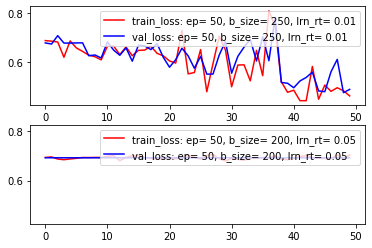


Best hyper parameters after tuning:
Number of epochs: 50
Learning rate: 0.01
Batch size: 250

Testing on the best model...

Accuracy and loss for train dataset:
Avg loss: 0.468289
Accuracy : 50.38
Classification report: 

              precision    recall  f1-score   support

           0       0.49      0.50      0.49     10944
           1       0.52      0.51      0.51     11676

    accuracy                           0.50     22620
   macro avg       0.50      0.50      0.50     22620
weighted avg       0.50      0.50      0.50     22620



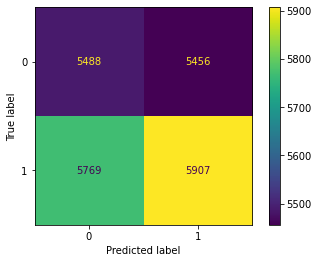


Accuracy and loss for validation dataset:
Avg loss: 0.474176
Accuracy : 49.45
Classification report: 

              precision    recall  f1-score   support

           0       0.48      0.50      0.49      2728
           1       0.51      0.49      0.50      2928

    accuracy                           0.49      5656
   macro avg       0.49      0.49      0.49      5656
weighted avg       0.50      0.49      0.49      5656



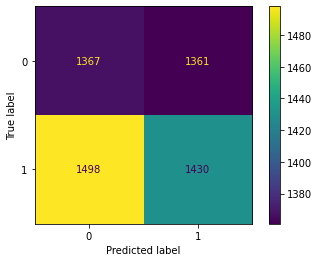


Accuracy and loss for test dataset:
Avg loss: 0.467587
Accuracy : 49.99
Classification report: 

              precision    recall  f1-score   support

           0       0.48      0.49      0.49      4280
           1       0.52      0.51      0.51      4557

    accuracy                           0.50      8837
   macro avg       0.50      0.50      0.50      8837
weighted avg       0.50      0.50      0.50      8837



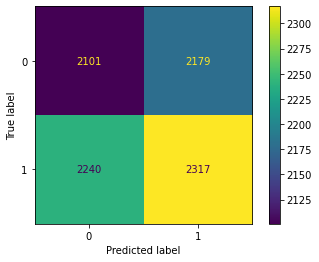


Time taken: 33.3966224193573
Done!


In [151]:
import time
from sklearn.metrics import accuracy_score
#hyper_parameters = {"epoch": [40, 25, 25], "batch_size": [5, 10, 5],
#                        "learning_rate": [0.05, 0.01, 0.05]}
#hyper_parameters = {"epoch": [40, 25, 25], "batch_size": [15, 10, 5],
#                    "learning_rate": [0.05, 0.01, 0.05]}

hyper_parameters = {"epoch": [50, 50], "batch_size": [250, 200], "learning_rate": [0.01, 0.05]}
    
min_loss = 99999999
max_accuracy = -1
best_at_epoch = -1
best_batch_size = -1
best_lrn_rt = -1
best_epochs = -1
num_layers = 4
hidden_nodes = [16, 16]

fig, ax = plt.subplots(len(hyper_parameters["epoch"]), 1, sharey=True)

start = time.time()
for it in range(len(hyper_parameters["epoch"])):
    epochs = hyper_parameters["epoch"][it]
    batch_size = hyper_parameters["batch_size"][it]
    lrn_rt = hyper_parameters["learning_rate"][it]
    '''if file_name == 'tokenized_features.csv':
            model = ClassificationModel(num_layers, nodes_hidn)
        else:
            model = ClassificationModel(num_layers, nodes_hidn, n_inputs=303)
    '''
    model = ClassificationModel(num_layers, hidden_nodes)
    print("\nRunning training with following hyper parameters:")
    print(f"Number of epochs: {str(epochs)}")
    print(f"Batch size: {str(batch_size)}")
    print(f"Learning rate: {str(lrn_rt)}")

    plot_X = np.arange(0, epochs, 1)
    train_loss = []
    val_loss = []

    for t in range(epochs):
        print(f"\nEpoch {t + 1}\n-------------------------------")
        print("\nTraining...")
        temp_loss = train_model(train_dataset, batch_size, lrn_rt, model)["loss"]
        train_loss.append(temp_loss)
        print("\nValidation...")
        val_res = evaluate_model(val_dataset, model)
        val_loss.append(val_res['loss'])
        predictions = val_res['predictions']
        pred_acc = round(accuracy_score(val_test.label, predictions) * 100, 2)
        
        print(f"Accuracy: {pred_acc} %, Avg loss: {val_res['loss']:>8f} \n")
        if val_res['loss'] < min_loss:
            #max_accuracy = pred_acc
            min_loss = val_res['loss']
            best_lrn_rt = lrn_rt
            best_batch_size = batch_size
            best_at_epoch = t
            best_epochs = epochs
            torch.save(model.state_dict(), 'weights_only.pth')
        
        
    if len(hyper_parameters["epoch"]) == 1:
        ax.plot(plot_X, train_loss, color='red',
                label= f"train_loss: ep= {epochs}, b_size= {batch_size}, lrn_rt= {lrn_rt}")
        ax.plot(plot_X, val_loss, color='blue',
                label= f"val_loss: ep= {epochs}, b_size= {batch_size}, lrn_rt= {lrn_rt}")
        ax.legend(loc='upper right')
    else:
        ax[it].plot(plot_X, train_loss, color='red',
                    label= f"train_loss: ep= {epochs}, b_size= {batch_size}, lrn_rt= {lrn_rt}")
        ax[it].plot(plot_X, val_loss, color='blue',
                    label= f"val_loss: ep= {epochs}, b_size= {batch_size}, lrn_rt= {lrn_rt}")
        ax[it].legend(loc='upper right')

plt.show()
    
print("\nBest hyper parameters after tuning:")
print(f"Number of epochs: {best_epochs}")
print(f"Learning rate: {best_lrn_rt}")
print(f"Batch size: {best_batch_size}")

model_new = ClassificationModel(num_layers, hidden_nodes)
model_new.load_state_dict(torch.load('weights_only.pth'))

print("\nTesting on the best model...")
print("\nAccuracy and loss for train dataset:")
results = evaluate_model(train_dataset, model_new)
print_eval_results(y_train, results)

print("\nAccuracy and loss for validation dataset:")
results = evaluate_model(val_dataset, model_new)
print_eval_results(val_test, results)

print("\nAccuracy and loss for test dataset:")
results = evaluate_model(test_dataset, model_new)
print_eval_results(y_test, results)
    
end = time.time()

print("\nTime taken: " + str(end - start))
print("Done!")